In [1]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

GET DATA

In [3]:
ROOT = './data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"

In [4]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

In [5]:
data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
files_path

['./data/train/Alligator/17250018551_eaf395294d_b.jpg',
 './data/train/Alligator/27380865196_f09bf12e6c_b.jpg',
 './data/train/Alligator/29033845108_9ff9b5858e_b.jpg',
 './data/train/Alligator/29096466125_fe8443418f_b.jpg',
 './data/train/Alligator/3194806745_1465ae0373_b.jpg',
 './data/train/Alligator/3194815487_db71ef667e_b.jpg',
 './data/train/Alligator/3194860899_640ce169ac_b.jpg',
 './data/train/Alligator/3195652916_92140de2bb_b.jpg',
 './data/train/Alligator/33182094940_48850d8a40_b.jpg',
 './data/train/Alligator/33368379685_ddbb759a50_b.jpg',
 './data/train/Alligator/33408445492_c5ce051fcc_b.jpg',
 './data/train/Alligator/34308654741_4566920fb7_b.jpg',
 './data/train/Alligator/34315117501_be413bb8f2_b.jpg',
 './data/train/Alligator/34338838754_079a3bd632_b.jpg',
 './data/train/Alligator/3582400631_9137a4aa27_b.jpg',
 './data/train/Alligator/3731556743_b1bac99641_b.jpg',
 './data/train/Alligator/41057193241_14521244f4_b.jpg',
 './data/train/Alligator/45070595214_f4cf344c6c_b.jpg'

In [6]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

IMAGE EMBEDDING

In [7]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

/home/heigetvu/anaconda3/envs/aio-hw2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
img = Image.open('./data/train/Alligator/3194806745_1465ae0373_b.jpg')
get_single_image_embedding(image=img)

array([ 4.19153459e-02,  5.04022129e-02, -3.18421945e-02,  1.57586355e-02,
        3.24370749e-02, -3.28146368e-02,  1.24833230e-02,  1.40465228e-02,
        6.70867637e-02,  3.97149064e-02, -1.14405155e-02, -6.58616237e-03,
        7.58718373e-03, -2.41856221e-02,  2.06776299e-02, -4.44029749e-04,
       -3.99775133e-02,  3.31239328e-02, -1.35905994e-02,  4.23526298e-03,
       -5.00649363e-02,  4.07075249e-02,  2.38254340e-03, -2.31531505e-02,
       -1.36865294e-02, -6.60159141e-02,  2.19501350e-02, -3.27001140e-03,
        2.29268661e-03,  3.33440490e-02, -1.55319236e-02, -4.50281333e-03,
       -1.62874591e-02,  6.74001947e-02, -1.37527166e-02, -1.26829743e-02,
       -2.53370367e-02, -2.17380305e-03, -7.84435570e-02,  9.81214829e-03,
        2.49161627e-02,  3.04546617e-02, -1.53143320e-03, -2.57193148e-02,
        5.10055795e-02, -6.77663535e-02,  1.25536239e-02,  4.57499363e-02,
        2.14542020e-02,  2.33087335e-02, -3.49466652e-02,  4.94681560e-02,
        1.56571195e-02,  

CHROMADB COSINE SIMILARITY COLLECTION

In [10]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [11]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                           metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

2327it [02:29, 15.59it/s]


SEARCH IMAGE WITH COSINE SIMILARITY COLLECTION

In [12]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [13]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[2]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [14]:
cosine_results

{'ids': [['id_50', 'id_46', 'id_48', 'id_39', 'id_55']],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None, None, None, None, None]],
 'distances': [[0.14471185207366943,
   0.15821588039398193,
   0.16126853227615356,
   0.17386651039123535,
   0.18446087837219238]]}

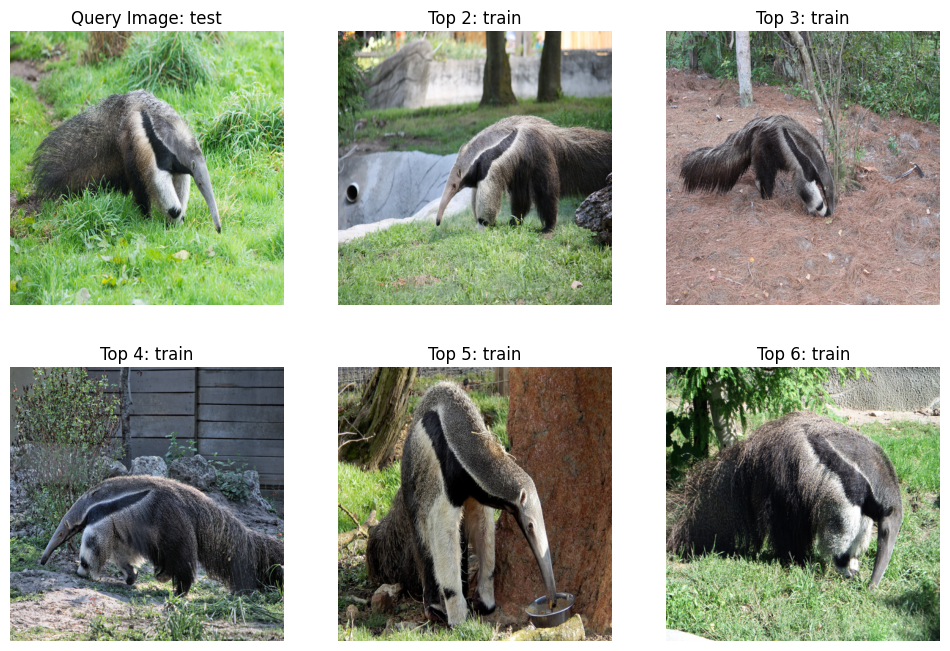

In [15]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)